In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmos
h = cosmos.H0.value/100
from astropy.io import fits
import healpy as hp

In [2]:
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery
sfd = SFDQuery()

In [72]:
f = fits.open('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS_eBOSS_weight_maps/SDSS_WISE_imageprop_nside512.fits')
# f = fits.open('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS_eBOSS_weight_maps/SDSSimageprop_Nside512.fits')

In [73]:
data = f[1].data

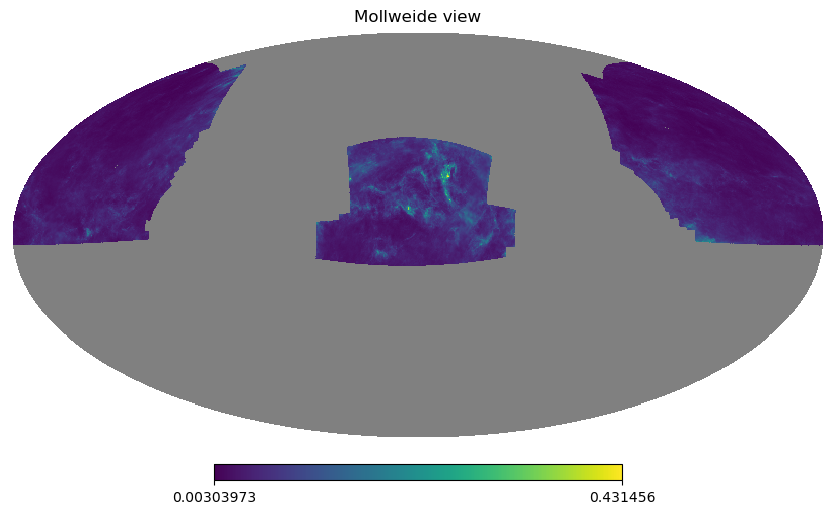

In [58]:
hp.mollview(data['EBV'])

In [74]:
random_n = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_random-NGC-vDR16.fits')
random_s = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_random-SGC-vDR16.fits')
random_all = np.hstack((random_n, random_s))

In [75]:
quasar_n = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_data-NGC-vDR16.fits')
quasar_s = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_data-SGC-vDR16.fits')
quasar_all = np.hstack((quasar_n, quasar_s))

quasar_cata = np.zeros(len(quasar_all), dtype=[('ra', 'f8'), ('dec', 'f8'), ('z', 'f8'), ('w', 'f8')])
quasar_cata['ra'] = quasar_all['RA']
quasar_cata['dec'] = quasar_all['DEC']
quasar_cata['z'] = quasar_all['Z']
quasar_cata['w'] = quasar_all['WEIGHT_SYSTOT']*quasar_all['WEIGHT_NOZ']*quasar_all['WEIGHT_CP']*quasar_all['WEIGHT_FKP']

In [76]:
Nside = 512
Npix = hp.nside2npix(Nside)
print(f'scale: {hp.nside2resol(Nside, True)} arcmin')

scale: 6.870972823634812 arcmin


In [77]:
pix = hp.ang2pix(Nside, np.deg2rad(90 - quasar_cata['dec']), np.deg2rad(quasar_cata['ra']))
pix_u = np.unique(pix)

pix_r = hp.ang2pix(Nside, np.deg2rad(90 - random_all['DEC']), np.deg2rad(random_all['RA']))
pix_ur = np.unique(pix_r)

In [78]:
# theta, phi = hp.pix2ang(Nside, pix_u)
# dec = 90 - np.rad2deg(theta)
# ra = np.rad2deg(phi)
# coord = SkyCoord(ra=ra, dec=dec, unit='deg')
# ebv_noz = sfd(coord)

ebv_noz = data['EBV'][pix_u]
# non-zero pixels


# theta, phi = hp.pix2ang(Nside, pix_ur)
# dec = 90 - np.rad2deg(theta)
# ra = np.rad2deg(phi)
# coord = SkyCoord(ra=ra, dec=dec, unit='deg')
# ebv_random = sfd(coord)
ebv_random = data['EBV'][pix_ur]

# random pixels

count = np.bincount(pix, minlength=Npix)                                            # number count in each area
count_w = np.bincount(pix, minlength=Npix, weights=quasar_cata['w'])          # number count weighted

Nbins = 10
bin_edge = np.linspace(0, 0.15, Nbins+1, True)
bin_center = (bin_edge[1:] + bin_edge[:-1])/2

In [79]:
# random pixels
count_all = count[pix_ur]
count_w_all = count_w[pix_ur]
A = ebv_random

dig = np.digitize(A, bin_edge)

count_mid = []

for i in range(1, Nbins+1):
    counts = count_all[dig == i]
    count_mid.append(counts.mean())

count_mid_w = []
for i in range(1, Nbins+1):
    counts = count_w_all[dig == i]
    count_mid_w.append(counts.mean())

count_all_m = np.array(count_mid)
count_w_all_m = np.array(count_mid_w)

In [80]:
# non-zero pixels
count_nozero = count[pix_u]
count_w_nozero = count_w[pix_u]

A = ebv_noz
dig = np.digitize(A, bin_edge)

count_mid = []

for i in range(1, Nbins+1):
    counts = count_nozero[dig == i]
    count_mid.append(counts.mean())

count_mid_w = []
for i in range(1, Nbins+1):
    counts = count_w_nozero[dig == i]
    count_mid_w.append(counts.mean())

count_noz_m = np.array(count_mid)
count_w_noz_m = np.array(count_mid_w)

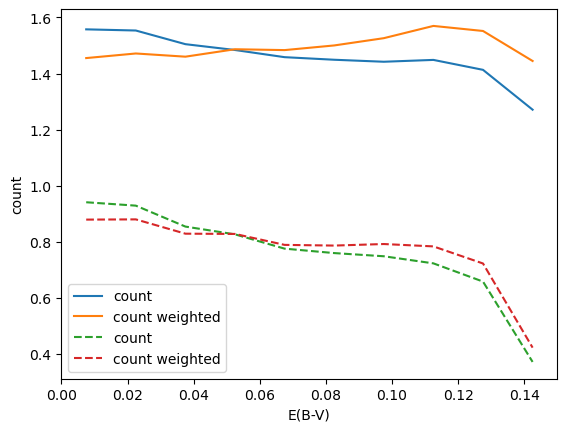

In [81]:
plt.plot(bin_center, count_noz_m, label='count')
plt.plot(bin_center, count_w_noz_m, label='count weighted')

plt.plot(bin_center, count_all_m, '--', label='count')
plt.plot(bin_center, count_w_all_m, '--', label='count weighted')

plt.xlim(0, 0.15)

plt.xlabel('E(B-V)')
plt.ylabel('count')
plt.legend()

In [82]:
ave_count_noz = count_nozero.mean()
ave_count_w_noz = count_w_nozero.mean()
ave_count_all = count_all.mean()
ave_count_w_all = count_w_all.mean()

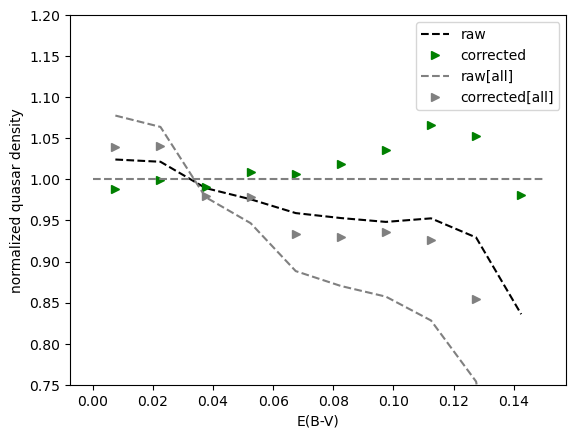

In [83]:
plt.plot(bin_center, count_noz_m/ave_count_noz, '--', color='black', label='raw')
plt.plot(bin_center, count_w_noz_m/ave_count_w_noz, '>', color='green', label='corrected')

plt.plot(bin_center, count_all_m/ave_count_all, '--', color='gray', label='raw[all]')
plt.plot(bin_center, count_w_all_m/ave_count_w_all, '>', color='gray', label='corrected[all]')
plt.hlines(1, xmin=0, xmax=0.15, linestyles='--', colors='grey')

plt.ylim(0.75, 1.2)
plt.xlabel('E(B-V)')
plt.ylabel('normalized quasar density')
plt.legend()

In [52]:
from scipy.stats import linregress
regress = linregress(ebv_noz, count_nozero / ave_count_noz)
print('non zero pixels:', regress.slope, regress.intercept)
regress = linregress(ebv_random, count_all / ave_count_all)
print('random pixels:', regress.slope, regress.intercept)

non zero pixels: nan nan
random pixels: nan nan


In [16]:
import seaborn as sns

Text(0.5, 1.0, 'count weighted')

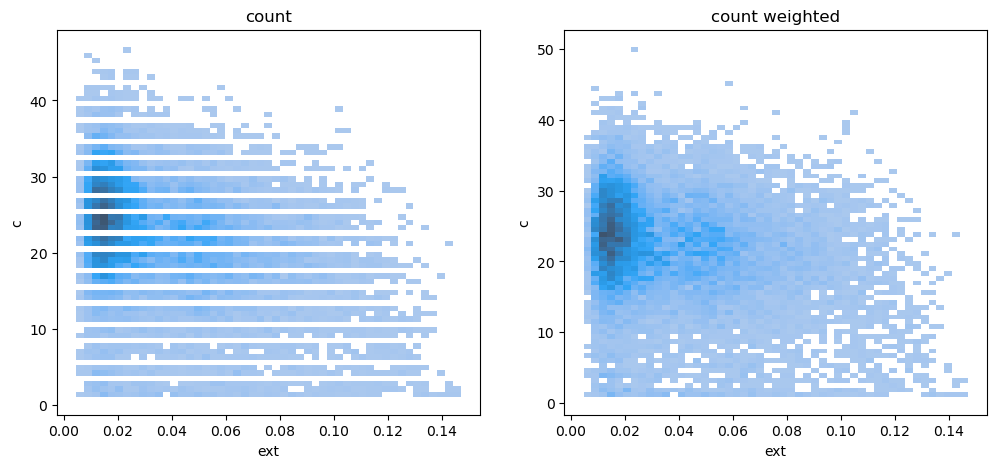

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot({'ext': ebv_noz, 'c': count_nozero}, x='ext', y='c', ax=ax[0])

# ax[0].scatter()
ax[0].set_title('count')
sns.histplot({'ext': ebv_random, 'c': count_w_nozero}, x='ext', y='c', ax=ax[1])

# ax[1].scatter(ext_nozero[:,0], count_2_nozero)
ax[1].set_title('count weighted')